# CAPSTONE PROJECT 2: A COMPUTER VISION MODEL WHICH DETECTS BONE FRACTURES IN THE UPPER EXTREMITIES NAMELY: WRISTS, FOREARMS, UPPER ARM, & SHOULDER FRACTURES
#### Exploratory Data Analysis


***
Goal: Explore the data relationships of all your features and understand how the
features compare to the response variable. <br>
- Build data profiles and tables
    - Inferential statistics
- Explore data relationships
    - Data visualization
- Feature Selection and Engineering <br>
Inferential Statistics Hint: do any particular results in your data strike you as abnormal?<br>
What hypotheses can you form (Null and Alternative hypotheses) which you could go on
to test? <br>Take some time to recall your statistical concepts, such as that the p-value of an
observation is the probability of seeing data at least as extreme as that observation, on
the assumption of the null hypothesis.
Data Visualization Hint: recall your matplotlib and seaborn functions for data
visualization: <br> matplotlib:
- plt.plot()
- plt.xlabel()
- plt.show()
- plt.hist(), <br>
Seaborn: <br>
- sns.relplot()
- sns.lmplot()
- sns.catplot().
Remember to always start with an idea of what you want to achieve, and use these
libraries and their functions as your toolkit to make that idea a reality.
Feature Selection and Engineering Hint: feature selection is where data storytelling starts:
we tell a story as soon as we include certain features and omit others. But how we
manipulate - or engineer - those fields is just as important. <br>Recall the crucial elements to
feature engineering:
- If you have categorical features, you might need to one-hot encode them
- You may need to binarize your columns and bin your values.
- To handle missing data, think about how appropriate the methods of listwise
deletion, data imputation, replacing missing values with constants or simply
attempting to find the missing values are for your data.
- Think about whether you need to standardize, log-transform or normalize your
data, as well as statistically valid ways to remove outliers.<br>
Consider the following questions and use your understanding of your dataset to answer
them:<br>
- Are there variables that are particularly significant in terms of explaining the 
answer to your project question?
- Are there significant differences between subgroups in your data that may be
relevant to your project aim?
- Are there strong correlations between pairs of independent variables or between
an independent and a dependent variable?
- What are the most appropriate tests to use to analyze these relationships?
***

In [15]:
# Import modules:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Import any other relevent modules as they become necesary throughout the project.
import sklearn as skl
import skimage as ski

In [6]:
#Import the data as Pandas DataFrames: df_test, df_train, df_val
data_links = [r'C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\df_test.csv', 
              r'C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\df_train.csv', 
              r'C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\df_val.csv']

def multi_df(list):
    temp_list = []
    for i in list:
        temp_list.append(pd.read_csv(i))
    return temp_list
    
df_test, df_train, df_val = multi_df(data_links)
    
    

In [14]:
# GLOBALS

# Project Main Directory path
dir_path = r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2"

# Data Paths
train_dir_path = r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\train"
val_dir_path = r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\valid"
test_dir_path = r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\test"


In [7]:
df_test.head()

,Unnamed: 0,images,labels,classes,class-num
0,0,distal-humerus-fracture-1_jpg.rf.831cb137cfcbd...,distal-humerus-fracture-1_jpg.rf.831cb137cfcbd...,humerus,4
1,1,image1_0_png.rf.99862308d714bff3f9c410adf5ca93...,image1_0_png.rf.99862308d714bff3f9c410adf5ca93...,humerus,4
2,2,image1_1000_png.rf.a53c5e186c03961bf88075c6e3e...,image1_1000_png.rf.a53c5e186c03961bf88075c6e3e...,humerus,4
3,3,image1_1015_png.rf.3b7320c3c40771fa5532bf713a7...,image1_1015_png.rf.3b7320c3c40771fa5532bf713a7...,humerus,4
4,4,image1_1015_png.rf.9181f8eb07451331e22381bacb3...,image1_1015_png.rf.9181f8eb07451331e22381bacb3...,humerus,4


In [8]:
df_train.head()

,Unnamed: 0,images,labels,classes,class-num
0,0,distal-humeral-fractures-2-_JPEG.rf.39ba3f5304...,distal-humeral-fractures-2-_JPEG.rf.39ba3f5304...,elbow positive,0
1,1,distal-humeral-fractures-2-_JPEG.rf.525ce87678...,distal-humeral-fractures-2-_JPEG.rf.525ce87678...,elbow positive,0
2,2,distal-humeral-fractures-2-_JPEG.rf.f9442db05e...,distal-humeral-fractures-2-_JPEG.rf.f9442db05e...,elbow positive,0
3,3,elbow-dislocation-with-coronoid-process-fractu...,elbow-dislocation-with-coronoid-process-fractu...,elbow positive,0
4,4,elbow-dislocation-with-coronoid-process-fractu...,elbow-dislocation-with-coronoid-process-fractu...,elbow positive,0


In [9]:
df_val.head()

,Unnamed: 0,images,labels,classes,class-num
0,0,coronoid-process-fracture_jpg.rf.71650459c69a9...,coronoid-process-fracture_jpg.rf.71650459c69a9...,elbow positive,0
1,1,image1_0_png.rf.d29cab92b154a83ca5bf7e40083673...,image1_0_png.rf.d29cab92b154a83ca5bf7e40083673...,fingers positive,1
2,2,image1_1000_png.rf.7eebc2918f75be5baf4c32a091e...,image1_1000_png.rf.7eebc2918f75be5baf4c32a091e...,fingers positive,1
3,3,image1_1026_png.rf.e9dc3004de762ddd0f75d8f17fb...,image1_1026_png.rf.e9dc3004de762ddd0f75d8f17fb...,fingers positive,1
4,4,image1_1029_png.rf.8f1dfb1982511a9b38867fa9444...,image1_1029_png.rf.8f1dfb1982511a9b38867fa9444...,fingers positive,1


These csv files double importet their indices so we will appropriately trim them.

In [12]:
df_train.drop(columns='Unnamed: 0', inplace=True)
df_test.drop(columns='Unnamed: 0', inplace=True)
df_val.drop(columns='Unnamed: 0', inplace=True)

Also just to make sure, we will import an image and superimpose it's respective label to make sure we can still use this data from the data wrangling portion of the project.

In [16]:
# a function for displaying an image for EDA (Borrowed from DataCamp Course: Make Images Come Alive with SciKit-Image)
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [32]:
# access image file path and store in image variable
i_file = rf"{train_dir_path}\images\{df_train['images'].iloc[0]}"
image = ski.io.imread(i_file)


In [ ]:
# access label data and superimpose on the image file.
os.read()

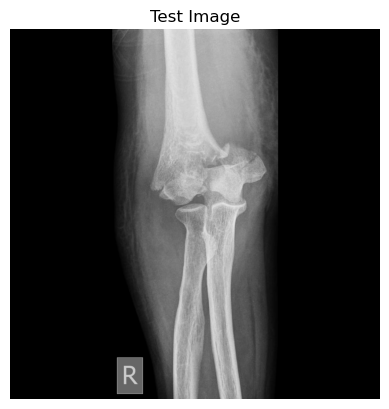

In [36]:
show_image(image, title="Test Image")